In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sts
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

from lib.utility_functions import *
from lib.exp4 import *

sns.set_style('white')
sns.set_context('paper')

colors = sns.color_palette().as_hex()

pd.set_option('display.max_columns', 40)

% matplotlib inline

/Users/gianni/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [95]:
tidy = pd.read_csv('./tidy_data.csv', index_col=0)
tidy['Condition'] = tidy['Condition'].map(lambda x: 'Untrained' if x == 'Naive' else x)

tidy['Num Dif'] = tidy['Num Pieces (final)'] - tidy['Num Pieces']
tidy.head()

In [97]:
mean_piv = tidy.pivot_table(
    index='Subject ID', values='Num Dif', columns=['Is Real', 'Num Pieces']
)

mean_piv['Condition'] = mean_piv.index.map(lambda x: tidy.loc[tidy['Subject ID'] == x, 'Condition'].values[0])

std_piv = tidy.pivot_table(
    index='Subject ID', values='Num Dif', columns=['Is Real', 'Num Pieces'],
    aggfunc=np.std
)

std_piv['Condition'] = mean_piv.index.map(lambda x: tidy.loc[tidy['Subject ID'] == x, 'Condition'].values[0])

In [99]:
c_filter = mean_piv['Condition'] == 'Trained'

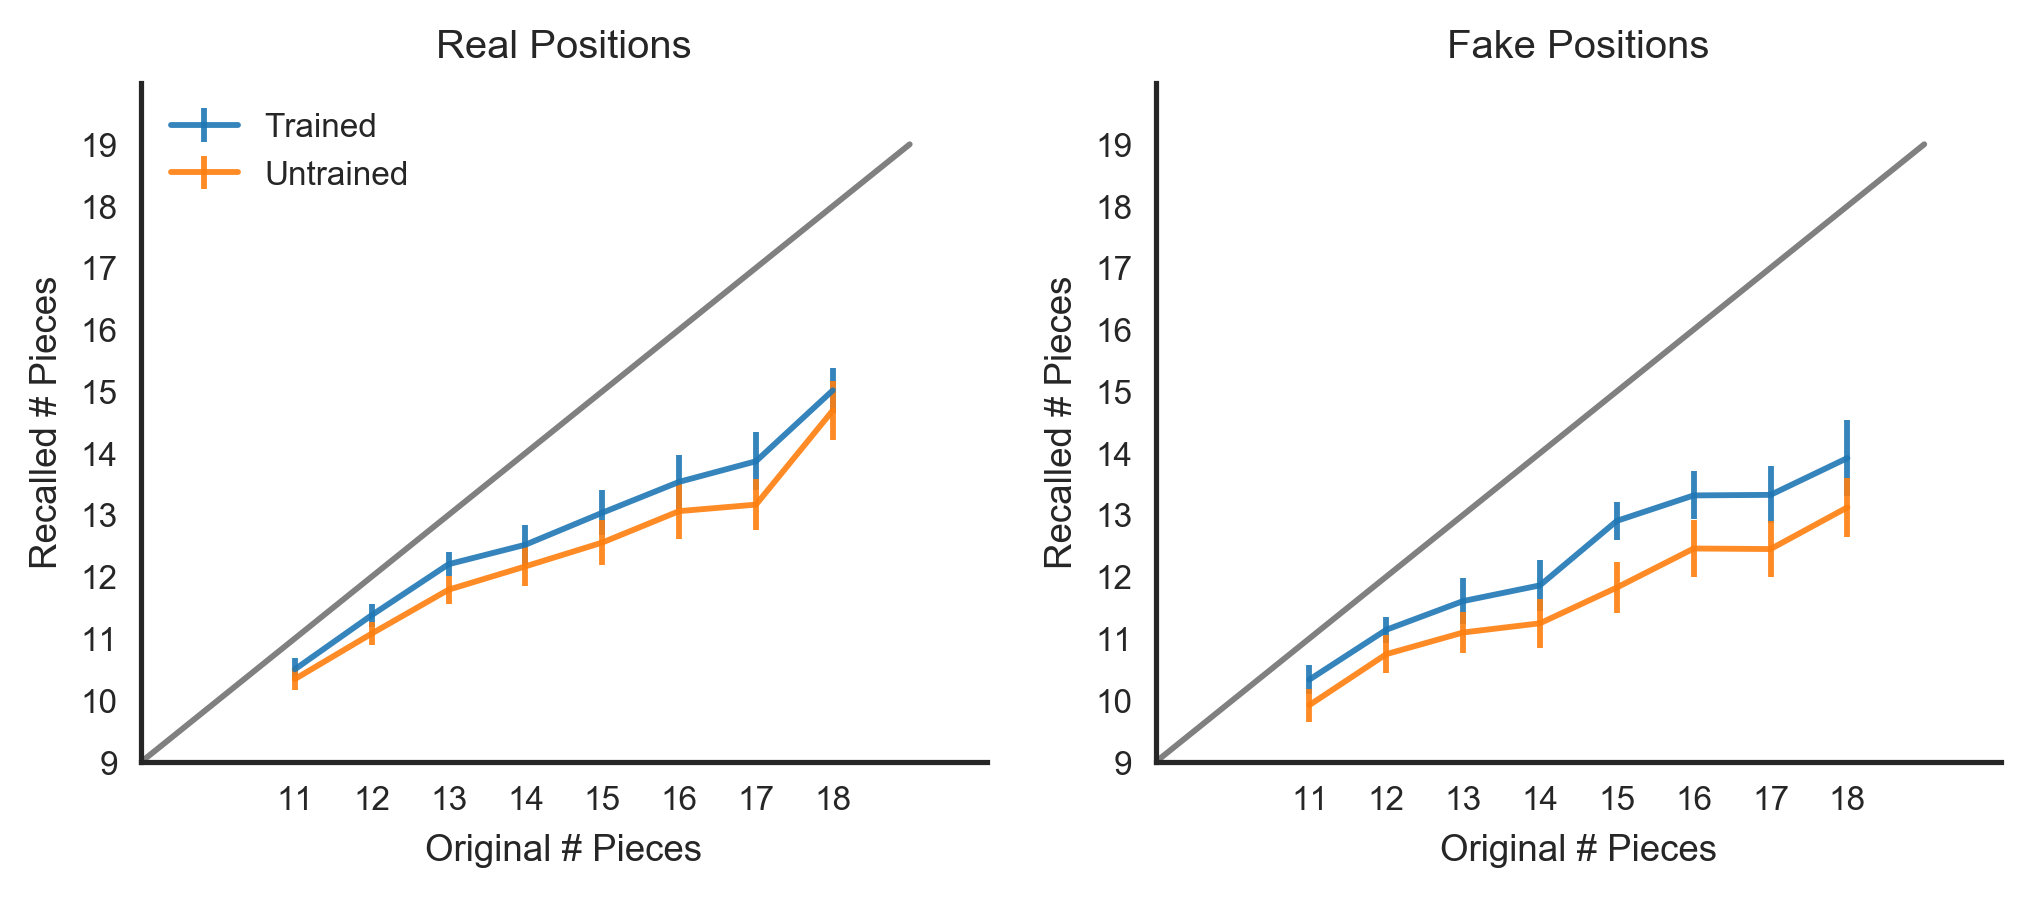

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)

tc_filter = tidy['Condition'] == 'Trained'
tp_filter = tidy['Is Real'] == True


def errbar_plot(df, ax, **kwargs):
    piv = df.pivot_table(
        index='Subject ID', values='Num Pieces (final)', columns='Num Pieces'
    )
    
    x = piv.columns.values
    y = piv.mean(axis=0)
    err = piv.std() / np.sqrt(len(piv))

    ax.errorbar(x, y, yerr=err, **kwargs)
    
    return None


## Real

ax = axes[0]

#### Trained

errbar_plot(
    tidy.loc[tc_filter & tp_filter], 
    ax=ax, color=colors[0], alpha=.9, label='Trained'
)

#### Untrained

errbar_plot(
    tidy.loc[~tc_filter & tp_filter],
    ax=ax, color=colors[1], alpha=.9, label='Untrained'
)


## Fake

ax = axes[1]

#### Trained

errbar_plot(
    tidy.loc[tc_filter & ~tp_filter], 
    ax=ax, color=colors[0], alpha=.9, label='Trained'
)

#### Untrained

errbar_plot(
    tidy.loc[~tc_filter & ~tp_filter],
    ax=ax, color=colors[1], alpha=.9, label='Untrained'
)

## Make it fancy

axes[0].plot(np.arange(20), color='grey')
axes[1].plot(np.arange(20), color='grey')

axes[0].legend(loc=0)

plt.setp(
    axes, 
    ylabel='Recalled # Pieces', xlabel='Original # Pieces', 
    xlim=[9, 20], ylim=[9, 20],
    xticks=np.arange(11, 19, 1), xticklabels=np.arange(11, 19, 1),
    yticks=np.arange(9, 20, 1), yticklabels=np.arange(9, 20, 1)
)
plt.setp(axes[0], title='Real Positions')
plt.setp(axes[1], title='Fake Positions')

sns.despine()

In [174]:
trained_piv = tidy.loc[tc_filter].pivot_table(
    index='Subject ID', columns='Num Pieces', values='Num Pieces (final)', 
    fill_value=0
)

untrained_piv = tidy.loc[~tc_filter].pivot_table(
    index='Subject ID', columns='Num Pieces', values='Num Pieces (final)', 
    fill_value=0
)

real_piv = tidy.loc[tp_filter].pivot_table(
    index='Subject ID', columns='Num Pieces', values='Num Pieces (final)', 
    fill_value=0
)

fake_piv = tidy.loc[~tp_filter].pivot_table(
    index='Subject ID', columns='Num Pieces', values='Num Pieces (final)', 
    fill_value=0
)

In [175]:
sts.ks_2samp(trained_piv.mean(axis=0).values, untrained_piv.mean(axis=0).values)

Ks_2sampResult(statistic=0.375, pvalue=0.5189424992880708)

In [176]:
sts.ks_2samp(real_piv.mean(axis=0).values, fake_piv.mean(axis=0).values)

Ks_2sampResult(statistic=0.25, pvalue=0.9289547774020107)

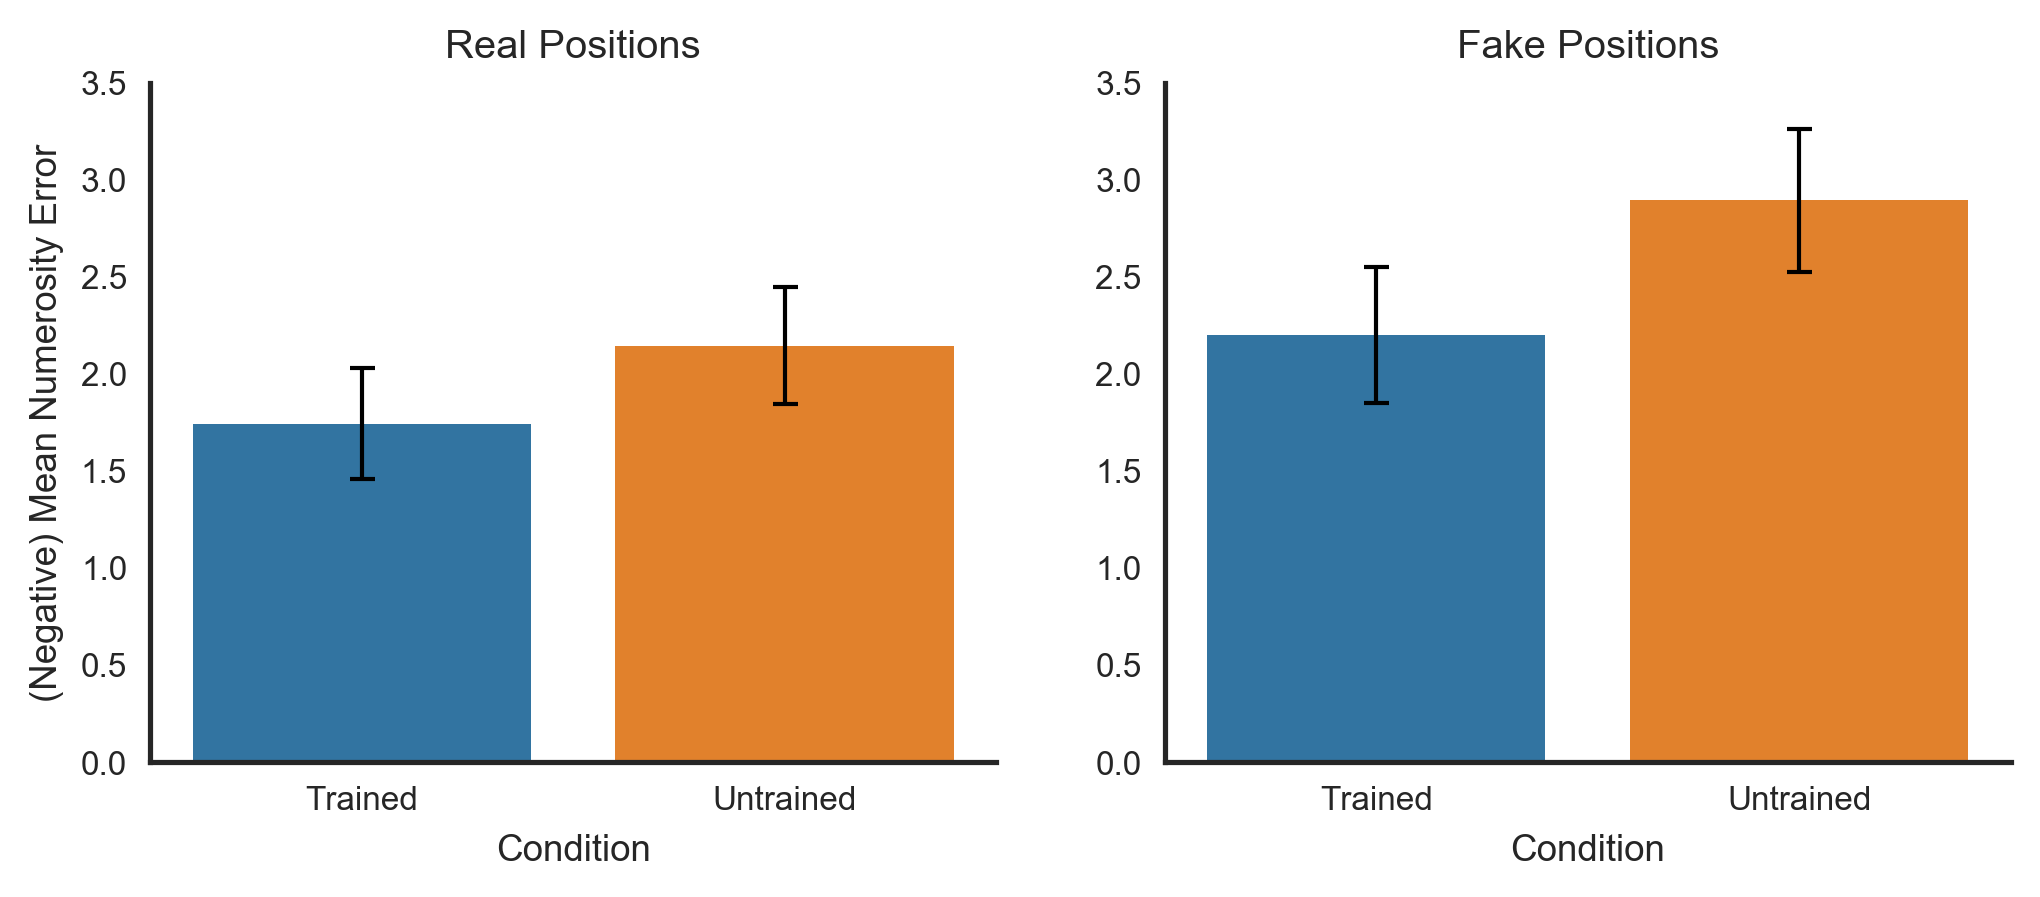

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)


def barplot(df, ax):
    piv_trained = df.loc[tc_filter].pivot_table(
        index='Subject ID', values='Num Dif'
    )

    piv_untrained = df.loc[~tc_filter].pivot_table(
        index='Subject ID', values='Num Dif'
    )

    trained_err = piv_trained['Num Dif'].std() / np.sqrt(len(piv_trained))
    untrained_err = piv_untrained['Num Dif'].std() / np.sqrt(len(piv_untrained))

    sns.barplot(
        x='Condition', y='Num Dif', data=df, 
        estimator=lambda x: -np.mean(x), ci=None,
        ax=ax
    )

    ax.errorbar(
        [0, 1], 
        [-piv_trained['Num Dif'].mean(), -piv_untrained['Num Dif'].mean()], 
        yerr=[trained_err, untrained_err],
        color='black', linestyle='none',
        elinewidth=1, capsize=3, capthick=1
    )
    
    return None


tidy_real = tidy.loc[tp_filter]
tidy_fake = tidy.loc[~tp_filter]

barplot(tidy_real, axes[0])
barplot(tidy_fake, axes[1])


plt.setp(axes, ylim=[0, 3.5])
plt.setp(axes[0], title='Real Positions', ylabel='(Negative) Mean Numerosity Error')
plt.setp(axes[1], title='Fake Positions', ylabel='')

sns.despine()

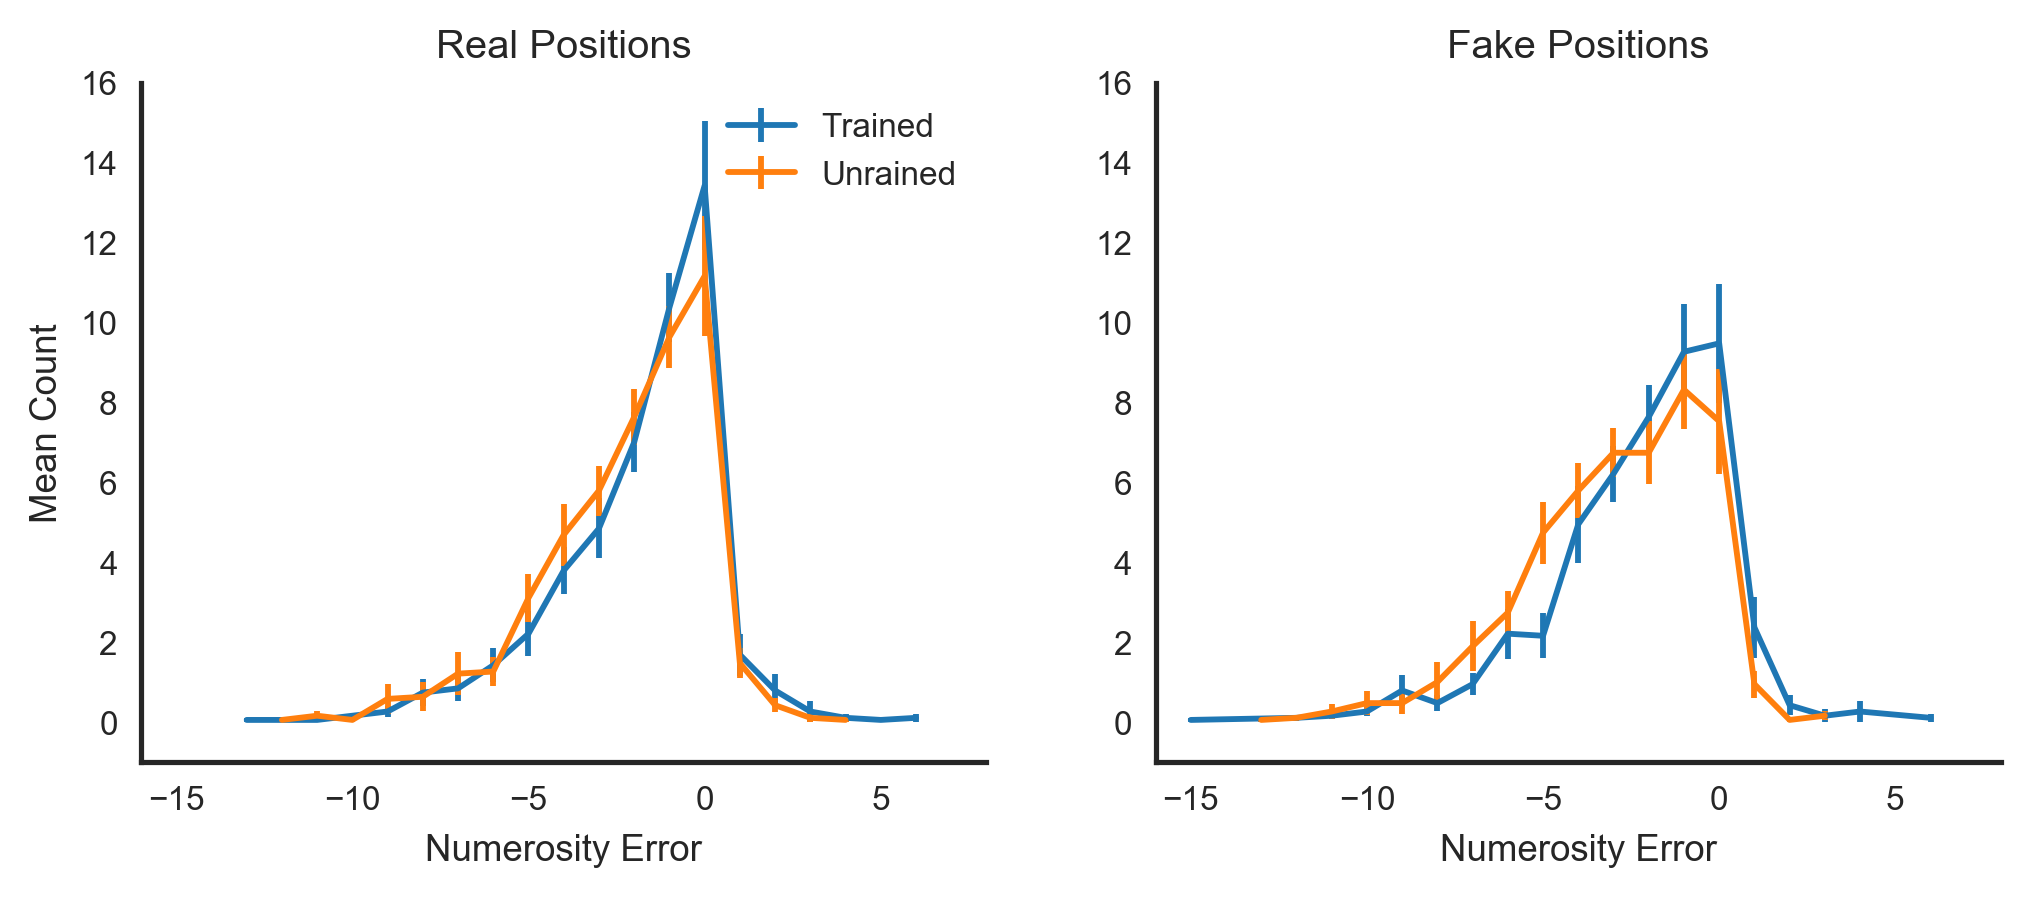

In [127]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)


def numerosity_error_hist(df, ax, **kwargs):
    piv = df.pivot_table(
        index='Subject ID', columns='Num Dif', values='Position ID', 
        aggfunc=len, fill_value=0
    )

    x = piv.columns.values
    y = piv.mean(axis=0)
    err = piv.std(axis=0) / np.sqrt(len(piv))

    ax.errorbar(x, y, yerr=err, **kwargs)
    
    return None


numerosity_error_hist(
    tidy.loc[tc_filter & tp_filter], 
    ax=axes[0], color=colors[0], label='Trained'
)

numerosity_error_hist(
    tidy.loc[~tc_filter & tp_filter], 
    ax=axes[0], color=colors[1], label='Unrained'
)

numerosity_error_hist(
    tidy.loc[tc_filter & ~tp_filter], 
    ax=axes[1], color=colors[0], label='Trained'
)

numerosity_error_hist(
    tidy.loc[~tc_filter & ~tp_filter], 
    ax=axes[1], color=colors[1], label='Unrained'
)


## Make it fancy

axes[0].legend(loc=0)

plt.setp(axes, xlim=[-16, 8], ylim=[-1, 16], xlabel='Numerosity Error')
plt.setp(axes[0], title='Real Positions', ylabel='Mean Count')
plt.setp(axes[1], title='Fake Positions', ylabel='')
sns.despine()

In [178]:
trained_piv = tidy.loc[tc_filter].pivot_table(
    index='Subject ID', columns='Num Dif', values='Position ID', 
    aggfunc=len, fill_value=0
)

untrained_piv = tidy.loc[~tc_filter].pivot_table(
    index='Subject ID', columns='Num Dif', values='Position ID', 
    aggfunc=len, fill_value=0
)

real_piv = tidy.loc[tp_filter].pivot_table(
    index='Subject ID', columns='Num Dif', values='Position ID', 
    aggfunc=len, fill_value=0
)

fake_piv = tidy.loc[~tp_filter].pivot_table(
    index='Subject ID', columns='Num Dif', values='Position ID', 
    aggfunc=len, fill_value=0
)

columns = set()


piv_list = [trained_piv, untrained_piv, real_piv, fake_piv]
for piv in piv_list:
    columns = columns.union(set(piv.columns.tolist()))
    
for piv in piv_list:
    absent = columns - set(piv.columns.tolist())
    print(len(piv.columns))
    for a in absent:
        piv[a] = 0
        
    print(len(piv.columns))


21
21
18
21
20
21
20
21


In [179]:
trained_piv

Num Dif,-15,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6
Subject ID,,,,,,,,,,,,,,,,,,,,,
1455888279254,0,0,0,0,0,0,0,0,0,1,8,5,20,23,23,12,4,0,0,0,0
1455896400640,0,0,0,0,0,0,1,1,6,3,8,15,15,22,25,0,0,0,0,0,0
1455905621344,0,0,0,0,0,0,0,0,0,0,0,3,3,28,55,7,0,0,0,0,0
1455913823185,1,1,1,1,1,3,1,1,2,2,6,14,11,23,24,4,0,0,0,0,0
1455999209774,0,0,0,0,0,0,0,0,0,1,5,6,19,28,31,5,1,0,0,0,0
1456159044009,0,0,1,1,1,2,8,2,9,8,18,15,13,10,8,0,0,0,0,0,0
1456327572567,0,0,0,0,0,0,0,0,0,0,3,3,15,28,42,5,0,0,0,0,0
1456358134808,0,0,0,0,1,1,1,3,12,12,14,12,17,12,9,1,1,0,0,0,0
1456775026965,0,0,0,0,0,0,1,1,1,0,6,10,14,30,26,7,0,0,0,0,0


In [180]:
freq_table = np.stack([trained_piv.sum(axis=0).values, untrained_piv.sum(axis=0).values])
chisq, p, dof, ex = sts.chi2_contingency(freq_table)
print('Chi-square test result: {:.2f}, p={:.4f}'.format(chisq, p))

Chi-square test result: 552.75, p=0.0000


In [160]:
freq_table = np.stack([real_piv.sum(axis=0).values, fake_piv.sum(axis=0).values])[:, :-1]
chisq, p, dof, ex = sts.chi2_contingency(freq_table)
print('Chi-square test result: {:.2f}, p={:.4f}'.format(chisq, p))

Chi-square test result: 255.58, p=0.0000


In [157]:
real_piv.sum(axis=0).values

array([  1,   1,   4,   1,  16,  26,  39,  51, 101, 161, 202, 278, 380,
       467,  60,  23,   7,   3,   1,   2,   0])

In [159]:
fake_piv.sum(axis=0).values

array([  1,   1,   4,   8,  14,  24,  28,  54,  94, 131, 204, 246, 273,
       334, 323,  63,   9,   6,   5,   2,   0])

In [ ]:
sns.violinplot()

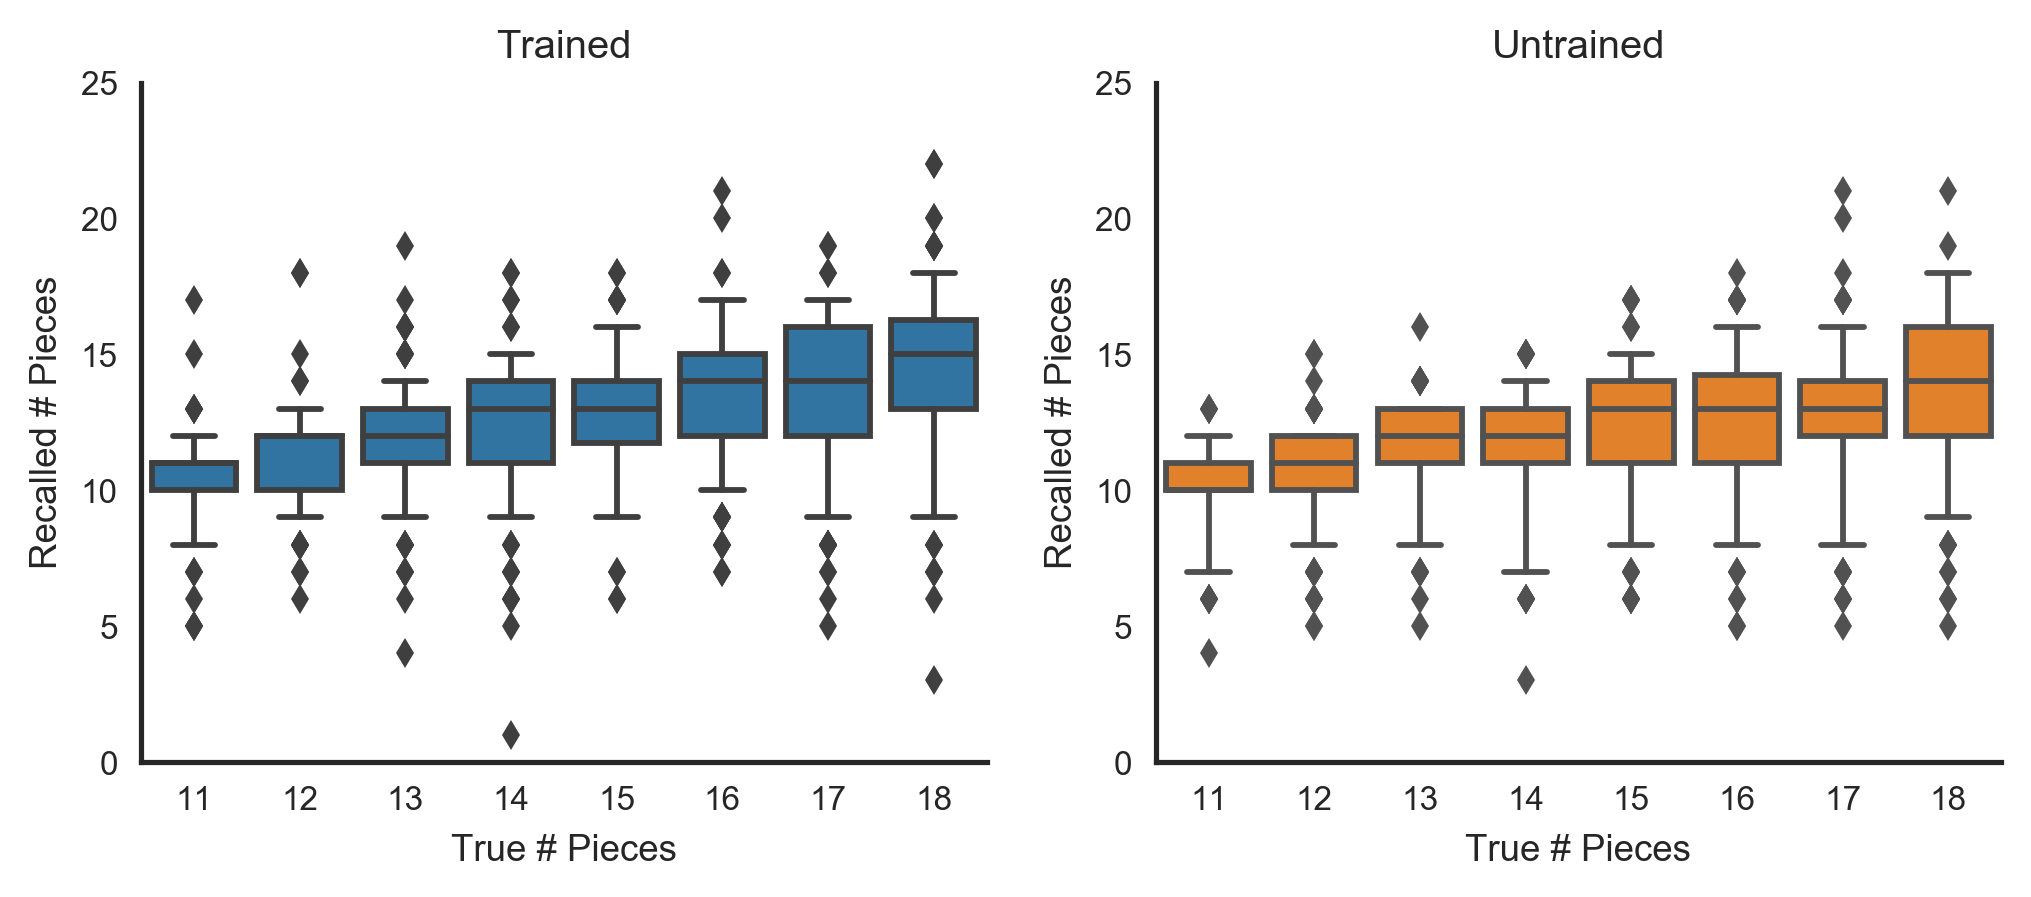

In [53]:
condition_filter = tidy['Condition'] == 'Trained'

fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)

sns.boxplot(
    x='Num Pieces', y='Num Pieces (final)', data=tidy.loc[condition_filter], 
    color=colors[0], ax=axes[0], bootstrap=1000, whis=[5, 95]
)

sns.boxplot(
    x='Num Pieces', y='Num Pieces (final)', data=tidy.loc[~condition_filter], 
    color=colors[1], ax=axes[1], bootstrap=1000, whis=[5, 95]
)

plt.setp(axes, xlabel='True # Pieces', ylabel='Recalled # Pieces', ylim=[0, 25])
plt.setp(axes[0], title='Trained')
plt.setp(axes[1], title='Untrained')
sns.despine()

In [23]:
tidy.head()

,Subject ID,Condition,Game Index,Position ID,Is Real,Black Position,White Position,Black Position (final),White Position (final),Response Time,Num Black Pieces,Num White Pieces,Num Pieces,Total Black Errors,Total White Errors,Total Errors,Type I Errors (black),Type I Errors (white),Type I Errors,Type II Errors (black),Type II Errors (white),Type II Errors,Type III Errors (black),Type III Errors (white),Type III Errors,Num Pieces (final),Numerosity Error
0,1464109333721,Trained,0,25.0,False,000000000011010000010100000001010001,001100000000001000001000000010100010,000000000011010000010100100001000000,000100000000100010001011000000000100,43.957,8,7,15,3,10,13.0,1,5,6,2,5,7,0,0,0,14,1
2,1464109333721,Trained,1,92.0,True,001011000000011000000101000000010100,000100000001100100000010100001101000,000001000001011000000101000000010100,000100000000100100001010100000101000,36.897,9,9,18,3,3,5.0,0,1,1,2,1,3,0,1,1,16,2
4,1464109333721,Trained,2,16.0,False,100100000001010000000100000000101000,000010000010000100001001000001000000,100100000001010000000101000000100000,000001000010000100001000000000000000,17.922,7,6,13,2,4,5.0,0,1,1,1,2,3,0,1,1,11,2
6,1464109333721,Trained,3,75.0,True,000001001000101100001001000000010000,000100000001010000010110000000001000,000001001001001100000101000000010000,000100000000110000000010000000001000,22.380,8,7,15,4,4,5.0,0,0,0,1,1,2,1,2,3,13,2
8,1464109333721,Trained,4,69.0,True,000101000101100000001100000000000000,000000000010011000000001000000111000,000101000101100000001100000000000000,000000000010011000000001000000111000,20.494,7,7,14,0,0,0.0,0,0,0,0,0,0,0,0,0,14,0


In [22]:
from matplotlib.gridspec import GridSpec

In [31]:
def reg_info(tidy_filter, x_name, y_name):
    x = tidy.loc[tidy_filter, x_name].values
    y = tidy.loc[tidy_filter, y_name].values
    
    res = sts.linregress(x, y)
    
    return x, y, res.slope, res.intercept

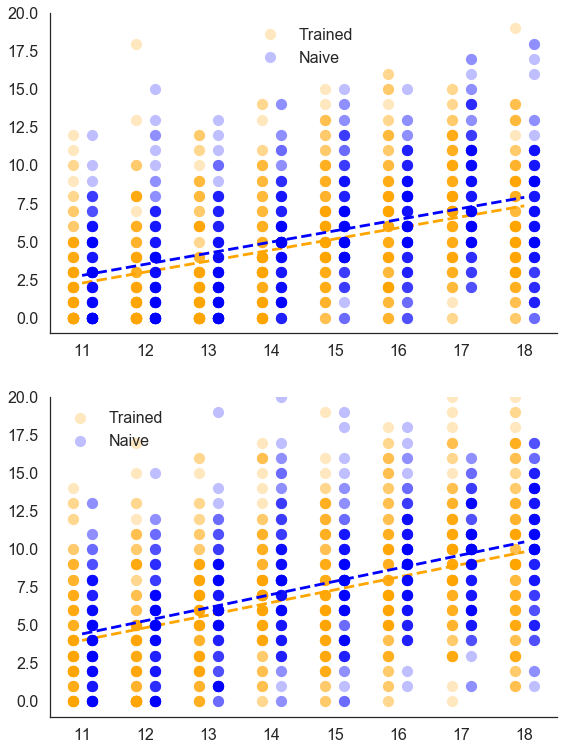

In [43]:
fig = plt.figure(figsize=(20, 20))
gs = GridSpec(3, 2, )

# Real vs fake

type_filter = tidy['Is Real']

axes = []
ax = plt.subplot(gs[0, 0])
axes.append(ax)
# Trained condition

x, y, m, b = reg_info(condition_filter & type_filter, 'Num Pieces', 'Total Errors')

ax.plot(x-.15, y, linestyle='none', marker='o', label='Trained', color='orange', alpha=.25)

res = sts.linregress(x, y)
m = res.slope
b = res.intercept

ax.plot([x.min(), x.max()], [m*x.min()+b, m*x.max()+b], linestyle='--', color='orange')

x, y, m, b = reg_info(~condition_filter & type_filter, 'Num Pieces', 'Total Errors')

ax.plot(x+.15, y, linestyle='none', marker='o', label='Naive', color='blue', alpha=.25)

res = sts.linregress(x, y)
m = res.slope
b = res.intercept

ax.plot([x.min(), x.max()], [m*x.min()+b, m*x.max()+b], linestyle='--', color='blue')

ax.legend(loc=0)

ax = plt.subplot(gs[1, 0])
axes.append(ax)
# Trained condition

x, y, m, b = reg_info(condition_filter & ~type_filter, 'Num Pieces', 'Total Errors')

ax.plot(x-.15, y, linestyle='none', marker='o', label='Trained', color='orange', alpha=.25)

res = sts.linregress(x, y)
m = res.slope
b = res.intercept

ax.plot([x.min(), x.max()], [m*x.min()+b, m*x.max()+b], linestyle='--', color='orange')

x, y, m, b = reg_info(~condition_filter & ~type_filter, 'Num Pieces', 'Total Errors')

ax.plot(x+.15, y, linestyle='none', marker='o', label='Naive', color='blue', alpha=.25)

res = sts.linregress(x, y)
m = res.slope
b = res.intercept

ax.plot([x.min(), x.max()], [m*x.min()+b, m*x.max()+b], linestyle='--', color='blue')

ax.legend(loc=0)

plt.setp(axes, ylim=[-1, 20])
sns.despine()

In [28]:
res.

LinregressResult(slope=0.7248329156223893, intercept=-5.704156223893065, rvalue=0.4350527312215738, pvalue=2.0903472723704422e-43, stderr=0.049729397537910856)